# Date-a-Scientist
This is a Machine Learning project that encourages thinking and practical application of concepts reviewd during the Codecademy's Machine Learning specialization. In this project, we will analyze data from OKCupid, an app that focuses on using multiple choice and short answers to match users

## Introduction
The task was to utilize the given dataset to produce a Machine Learning model. This is an open-ended assignment, so I formulated the following `Objective`:

<div class="alert alert-block alert-success">
Create a recommender system, using a KMeans clustering Unsipervised Learning Algorithm to group profiles by similarity, and output recommendations based on that closeness.
</div>

This project is divided into the following parts:

1. Clean the data
    - Drop unused columns
    - Handle missing values in each of the columns
    - Look for and correct errors in column inputs (misspelling, incoherent values, null values)
2. Conduct Feature engineering
    - Derive other columns from existing ones
    - Transform categorical data into numbers using different encoders
    - Conduct `PCA` in order to reduce dimensions, and improve algorithm performance
3. Create and tune model
    - Use the elbow model to tune the number of clusters for the KMeans algorithm
    - Create new data points and make recommendations for these
    - Select the final list of recommendations
4. Write conclusions 
    - Reflect about the obtained results
5. Reflect on further research
    - Reflect on possible improvements and other uses for this project

## Clean the data

First, import the necessary libraries and tools, to then start by peeking into the dataset and the information it contains. We can see that there are some columns that contain text (named essay0, essay1, etc.) since the algorithm will not perform Natural Language Processing, I will drop these columns and investigate the rest.

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from category_encoders import BinaryEncoder
import glob

%matplotlib inline

In [7]:
files = glob.glob('profile*.csv')
df_list = []
for f in files:
    data = pd.read_csv(f)
    df_list.append(data)
df = pd.concat(df_list)

In [8]:
df=df.reset_index(drop=True)

In [9]:
df.columns

Index(['age', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'essay0',
       'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7',
       'essay8', 'essay9', 'ethnicity', 'height', 'income', 'job',
       'last_online', 'location', 'offspring', 'orientation', 'pets',
       'religion', 'sex', 'sign', 'smokes', 'speaks', 'status'],
      dtype='object')

In [10]:
features = df[ [col for col in df.columns if 'essay' not in col] ]
features.columns

Index(['age', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'ethnicity',
       'height', 'income', 'job', 'last_online', 'location', 'offspring',
       'orientation', 'pets', 'religion', 'sex', 'sign', 'smokes', 'speaks',
       'status'],
      dtype='object')

In this stage of the project, I will deal with the missing values in every column, I will also look at each column individually to understand if the values need further processing, such as tranformations or rearrangement, wich will be done as part of the feature engineering step of this project. These are the actions that I will perform in this cleaning step:

- Columns with complete entries: These columns do not have missing values, but I will look at them in future steps to see if they have mistakes like incorrect values. The columns in this group are: <br> `age`, `income`, `last_online`, `location`, `orientation`, `sex` and `status`.
- Columns with missing information: The `offspring` column is missing almost 60% of all entries, it will be dropped due to lack of information.
- Columns with little missing values: `speaks` and `height` are missing a small number of entries, so the rows with the missing data will be dropped
- Columns to analyze individually: These columns will be analyzed one by one, to determine the best course of action for each one. The columns in this group are: <br> `body_type`, `diet`, `drinks`, `drugs`, `education`, `ethnicity`, `job`, `pets`, `religion`, `sign` and `smokes`.

In [11]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119892 entries, 0 to 119891
Data columns (total 21 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   age          119892 non-null  int64  
 1   body_type    109300 non-null  object 
 2   diet         71102 non-null   object 
 3   drinks       113922 non-null  object 
 4   drugs        91732 non-null   object 
 5   education    106636 non-null  object 
 6   ethnicity    108532 non-null  object 
 7   height       119886 non-null  float64
 8   income       119892 non-null  int64  
 9   job          103496 non-null  object 
 10  last_online  119892 non-null  object 
 11  location     119892 non-null  object 
 12  offspring    48770 non-null   object 
 13  orientation  119892 non-null  object 
 14  pets         80050 non-null   object 
 15  religion     79440 non-null   object 
 16  sex          119892 non-null  object 
 17  sign         97780 non-null   object 
 18  smokes       108868 non-

In [12]:
for column in features.columns:
    print(column)
    missing_values = features[column].isna().sum()
    print(f'Missing values: {missing_values}')
    print(f'Percentage missing values: {missing_values / len(features[column]) : .2%}', '\n')

age
Missing values: 0
Percentage missing values:  0.00% 

body_type
Missing values: 10592
Percentage missing values:  8.83% 

diet
Missing values: 48790
Percentage missing values:  40.69% 

drinks
Missing values: 5970
Percentage missing values:  4.98% 

drugs
Missing values: 28160
Percentage missing values:  23.49% 

education
Missing values: 13256
Percentage missing values:  11.06% 

ethnicity
Missing values: 11360
Percentage missing values:  9.48% 

height
Missing values: 6
Percentage missing values:  0.01% 

income
Missing values: 0
Percentage missing values:  0.00% 

job
Missing values: 16396
Percentage missing values:  13.68% 

last_online
Missing values: 0
Percentage missing values:  0.00% 

location
Missing values: 0
Percentage missing values:  0.00% 

offspring
Missing values: 71122
Percentage missing values:  59.32% 

orientation
Missing values: 0
Percentage missing values:  0.00% 

pets
Missing values: 39842
Percentage missing values:  33.23% 

religion
Missing values: 40452


In [13]:
features = features.drop('offspring', axis=1)

In [14]:
features = features.dropna(subset=['speaks','height'])

### Body type

This values are categorical, and can be filled with the most common category. There are also a lot of different categories, so I will group them to reduce dimensionality, and in further steps, these will be encoded using ono-hot encoding.

| New category | Old categories | 
| --- | --- |
| thin | this, skinny, used up |
| average | average |
| fit | fit, athletic, jacked |
| curvy | curvy, a little extra, full figured, overweight |
| rather not say | rather not say |

In [15]:
features['body_type'].value_counts()

average           29286
fit               25408
athletic          23618
thin               9412
curvy              7846
a little extra     5252
skinny             3548
full figured       2016
overweight          886
jacked              842
used up             710
rather not say      388
Name: body_type, dtype: int64

In [16]:
#Fill missing values with mode
features['body_type'] = features['body_type'].fillna('average')
#Reorder categories
def reorder_body_type(x):
    if x in ('thin', 'skinny', 'used up'):
        return 'thin'
    elif x in ('average', 'rather not say'):
        return x
    elif x in ('fit', 'athletic', 'jacked'):
        return 'fit'
    else:
        return 'curvy'
features['body_type'] = features['body_type'].apply(reorder_body_type)

### Diet

Fill missing values with 'anything', assuming that if this was important (or respondent had special needs), people would have filled with appropriate value. There are a lot of categories, in order to reduce complexity, I am going to create new categories from the old values as follows:

| New category | Old categories | 
| --- | --- |
| anything | 'mostly anything', 'anything', 'strictly anything' |
| vegetarian | 'mostly vegetarian', 'strictly vegetarian', 'vegetarian' |
| vegan | 'mostly vegan', 'strictly vegan', 'vegan' |
| special | 'mostly kosher', 'mostly halal', 'strictly halal', 'strictly kosher', 'halal', 'kosher' |
| other | 'mostly other', 'strictly other', 'other' |

In [17]:
features['diet'].value_counts()

mostly anything        33154
anything               12358
strictly anything      10220
mostly vegetarian       6880
mostly other            2014
strictly vegetarian     1750
vegetarian              1332
strictly other           902
mostly vegan             676
other                    662
strictly vegan           456
vegan                    272
mostly kosher            172
mostly halal              96
strictly halal            36
strictly kosher           36
halal                     22
kosher                    22
Name: diet, dtype: int64

In [18]:
features['diet'] = features['diet'].fillna('anything')

In [19]:
def new_diet_categories(diet):
    if diet in ['mostly anything', 'anything', 'strictly anything']:
        return 'anything'
    elif diet in ['mostly vegetarian', 'strictly vegetarian', 'vegetarian']:
        return 'vegetarian'
    elif diet in ['mostly vegan', 'strictly vegan', 'vegan']:
        return 'vegan'
    elif diet in ['mostly kosher', 'mostly halal', 'strictly halal', 'strictly kosher', 'halal', 'kosher']:
        return 'special'
    else:
        return 'other'
features['diet'] = features['diet'].apply(new_diet_categories)

### Drinks

Replace missing values with the mode

In [20]:
features.drinks.value_counts()

socially       83500
rarely         11908
often          10322
not at all      6532
very often       940
desperately      644
Name: drinks, dtype: int64

In [21]:
features['drinks'] = features['drinks'].fillna('socially')

### Drugs

Replace missing values with the mode

In [22]:
features.drugs.value_counts()

never        75400
sometimes    15460
often          820
Name: drugs, dtype: int64

In [23]:
features['drugs'] = features['drugs'].fillna('never')

### Education

Replace missing values with the mode. This column has a lot of categories, and I can't think of some logical groupping for all the different categories. Therefore, I will use Binary Encoding for this column, which will keep all the categories and transform them into a binary representation (encoding will be done in another step).

In [24]:
features.education.value_counts()

graduated from college/university    47876
graduated from masters program       17900
working on college/university        11424
working on masters program            3364
graduated from two-year college       3062
graduated from high school            2856
graduated from ph.d program           2540
graduated from law school             2244
working on two-year college           2146
dropped out of college/university     1990
working on ph.d program               1966
college/university                    1602
graduated from space camp             1314
dropped out of space camp             1046
graduated from med school              892
working on space camp                  890
working on law school                  538
two-year college                       444
working on med school                  422
dropped out of two-year college        382
dropped out of masters program         280
masters program                        272
dropped out of ph.d program            254
dropped out

In [25]:
features.education = features.education.fillna('graduated from college/university')

### Ethnicity

This column also had a lot of categories, which I grouped into fewer classes, but in doing so I changed the relative frequencies of the original types, putting `other` in second place while it was the fifth most common category before the transformation

In [26]:
features.ethnicity.value_counts()

white                                                                 65598
asian                                                                 12266
hispanic / latin                                                       5642
black                                                                  4012
other                                                                  3404
                                                                      ...  
middle eastern, indian, white                                             2
asian, middle eastern, black, white, other                                2
asian, middle eastern, indian, hispanic / latin, white, other             2
black, native american, indian, pacific islander, hispanic / latin        2
asian, black, indian                                                      2
Name: ethnicity, Length: 217, dtype: int64

In [27]:
ethnic_groups = ['white','asian','hispanic / latin','black','other']
features.ethnicity = features.ethnicity.apply(lambda x: x if x in ethnic_groups else 'other')
features.ethnicity.value_counts()

white               65598
other               32268
asian               12266
hispanic / latin     5642
black                4012
Name: ethnicity, dtype: int64

### Job

This column will also be filled with the mode. Since the number of categories is high, I don't find any obvious groupings, and it doesn't make sense to encode them into ordinal numbers, I will use another type of encoder called binary encoder for this column (this will be done in the feature engineering step)

In [28]:
features.job.value_counts()

other                                15174
student                               9760
science / tech / engineering          9688
computer / hardware / software        9414
artistic / musical / writer           8872
sales / marketing / biz dev           8770
medicine / health                     7350
education / academia                  7022
executive / management                4736
banking / financial / real estate     4528
entertainment / media                 4500
law / legal services                  2762
hospitality / travel                  2726
construction / craftsmanship          2042
clerical / administrative             1610
political / government                1414
rather not say                         872
transportation                         732
unemployed                             546
retired                                500
military                               408
Name: job, dtype: int64

In [29]:
features.job = features.job.fillna('other')

### Pets

`pets` was also filled with the mode. In this case, I will derive 3 new columns to capture the information contained in the original `pets`. This will not require further encoding.

In [30]:
features.pets.value_counts()

likes dogs and likes cats          29612
likes dogs                         14440
likes dogs and has cats             8622
has dogs                            8266
has dogs and likes cats             4662
likes dogs and dislikes cats        4058
has dogs and has cats               2948
has cats                            2806
likes cats                          2122
has dogs and dislikes cats          1104
dislikes dogs and likes cats         480
dislikes dogs and dislikes cats      392
dislikes cats                        244
dislikes dogs and has cats           162
dislikes dogs                         88
Name: pets, dtype: int64

In [31]:
features.pets = features.pets.fillna('likes dogs and likes cats')
#pets_likes_dogs
features['pets_likes_dogs'] = features['pets'].apply(lambda x: 1 if 'likes dogs' in x else 0)
#pets_likes_cats
features['pets_likes_cats'] = features['pets'].apply(lambda x: 1 if 'likes cats' in x else 0)
#has_pets
features['has_pets'] = features['pets'].apply(lambda x: 1 if 'has' in x else 0)
features = features.drop('pets', axis=1)

### Religion

There are 20226 missing values in `religion`, and the categories are all evenly distributed, so if the column is filled with the mode, the original values in the column will be heavily distorted.
After some consideration, I decided to drop the column because null values cannot be filled without skewing too much the distribution of the values, and dropping null values would drop many rows.

In [32]:
features.religion.isna().sum()

40426

In [33]:
features.religion.value_counts()

agnosticism                                   5432
other                                         5360
agnosticism but not too serious about it      5268
agnosticism and laughing about it             4990
catholicism but not too serious about it      4634
atheism                                       4346
other and laughing about it                   4236
atheism and laughing about it                 4148
christianity                                  3906
christianity but not too serious about it     3902
other but not too serious about it            3106
judaism but not too serious about it          3034
atheism but not too serious about it          2636
catholicism                                   2122
christianity and somewhat serious about it    1854
atheism and somewhat serious about it         1696
other and somewhat serious about it           1692
catholicism and laughing about it             1452
judaism and laughing about it                 1360
buddhism but not too serious ab

In [34]:
features = features.drop('religion', axis=1)

### Sign

There are a lot of different categories in this column, I could use another binary encoding but I will try to instead derive part of the information contained in this column, by creating another column that only states the importance of zodiac signs to the responder

In [35]:
features.sign.value_counts()

gemini and it&rsquo;s fun to think about         3562
scorpio and it&rsquo;s fun to think about        3540
leo and it&rsquo;s fun to think about            3380
libra and it&rsquo;s fun to think about          3296
taurus and it&rsquo;s fun to think about         3276
cancer and it&rsquo;s fun to think about         3194
pisces and it&rsquo;s fun to think about         3184
sagittarius and it&rsquo;s fun to think about    3162
aries and it&rsquo;s fun to think about          3146
virgo and it&rsquo;s fun to think about          3146
aquarius and it&rsquo;s fun to think about       3006
virgo but it doesn&rsquo;t matter                2994
leo but it doesn&rsquo;t matter                  2912
cancer but it doesn&rsquo;t matter               2906
gemini but it doesn&rsquo;t matter               2906
taurus but it doesn&rsquo;t matter               2900
libra but it doesn&rsquo;t matter                2816
aquarius but it doesn&rsquo;t matter             2814
sagittarius but it doesn&rsq

In [36]:
features.sign = features.sign.fillna(0)

In [37]:
def zodiac_matters(x):
    if x == 0:
        return 0
    lst = x.split()
    if len(lst) == 1 or 'matters a lot' in x:
        return 1
    return 0
features.sign = features.sign.apply(zodiac_matters)

### Smokes

Just fill with the mode

In [38]:
features.smokes.value_counts()

no                87712
sometimes          7570
when drinking      6080
yes                4456
trying to quit     2954
Name: smokes, dtype: int64

In [39]:
features.smokes = features.smokes.fillna('no')

### Age
This starts the analysis of the columns that were complete, as above, I will go through every column to see if there are things that need to be changed. 
In particular, for the age column we see there are a couple entries where the answer is above 100, we will drop these assuming they were mistakes.

In [40]:
features.age.describe()

count    119786.000000
mean         32.336083
std           9.452712
min          18.000000
25%          26.000000
50%          30.000000
75%          37.000000
max         110.000000
Name: age, dtype: float64

In [41]:
features[ features['age']>90 ]

,age,body_type,diet,drinks,drugs,education,ethnicity,height,income,job,...,location,orientation,sex,sign,smokes,speaks,status,pets_likes_dogs,pets_likes_cats,has_pets
2512,110,average,anything,socially,never,graduated from college/university,other,67.0,-1,other,...,"daly city, california",straight,f,0,no,english,single,1,1,0
25324,109,fit,other,socially,never,working on masters program,other,95.0,-1,student,...,"san francisco, california",straight,m,0,when drinking,english (okay),available,1,1,0
42512,110,average,anything,socially,never,graduated from college/university,other,67.0,-1,other,...,"daly city, california",straight,f,0,no,english,single,1,1,0
65324,109,fit,other,socially,never,working on masters program,other,95.0,-1,student,...,"san francisco, california",straight,m,0,when drinking,english (okay),available,1,1,0


In [42]:
features = features[features['age']<= 90]

### Income
This column was interesting. Despite being complete, most of the information is missing from this column. `80%` of respondents gave an answer of `-1`, which is akin to not responding at all and because of this the column will have to be dropped, due to lack of information 

In [43]:
features['income'].value_counts()

-1          96784
 20000       5904
 100000      3234
 80000       2222
 30000       2096
 40000       2010
 50000       1948
 60000       1472
 70000       1414
 150000      1262
 1000000     1042
 250000       298
 500000        96
Name: income, dtype: int64

In [44]:
percentage_missing =  48237 / len(features.income)
print(f'{percentage_missing:.2%} "missing" answers')

40.27% "missing" answers


In [45]:
#This column is not usable
features = features.drop('income', axis=1)

### Location
I will drop this column also, this time because `99%` of the respondents are from `California`, which means most machine learning algorithms will not be able to derive useful patterns from this variable.

In [46]:
features.location.value_counts()

san francisco, california         62056
oakland, california               14426
berkeley, california               8418
san mateo, california              2660
palo alto, california              2124
                                  ...  
south wellfleet, massachusetts        2
orange, california                    2
astoria, new york                     2
london, united kingdom                2
rochester, michigan                   2
Name: location, Length: 198, dtype: int64

In [47]:
people_from_california = features['location'].str.match(".*california.*").sum()
total_people = len(features['location'])
percentage_from_california = people_from_california / total_people
print(f'Percentage of people from California: {percentage_from_california:.2%}')

Percentage of people from California: 99.85%


In [48]:
features = features.drop('location', axis=1)

### Last online
I will drop this column, since it is not relevant to the clusters we are trying to make

In [49]:
features = features.drop('last_online', axis=1)

### Orientation, Sex and Status
These columns are complete and have a reasonable number of categories each one, there is no further need of transformation except for the encoding in a future st

In [50]:
features.orientation.value_counts()

straight    103118
gay          11134
bisexual      5530
Name: orientation, dtype: int64

In [51]:
features.sex.value_counts()

m    71582
f    48200
Name: sex, dtype: int64

In [52]:
features.status.value_counts()

single            111292
seeing someone      4128
available           3722
married              620
unknown               20
Name: status, dtype: int64

### Speaks

Virtually all the answer in this column have `english` in them, tehrefore I will derive another column which states if the respondent talks more than one language

In [53]:
features.speaks.str.contains('english').sum()#Rows from people who speak English

119782

In [54]:
len(features.speaks)#Total rows

119782

In [55]:
features.speaks.value_counts()

english                                                                43652
english (fluently)                                                     13254
english (fluently), spanish (poorly)                                    4118
english (fluently), spanish (okay)                                      3834
english (fluently), spanish (fluently)                                  2576
                                                                       ...  
english (fluently), urdu (poorly), japanese (poorly), french (okay)        2
english, spanish, hindi, c++                                               2
english (fluently), japanese (okay), thai (okay), chinese (poorly)         2
english (fluently), french (okay), italian (okay), hebrew (okay)           2
english (fluently), french, farsi                                          2
Name: speaks, Length: 7647, dtype: int64

In [56]:
features['speaks_other_than_english'] = features.speaks.apply(lambda x: 1 if len(x.split()) > 1 else 0)

In [57]:
features['speaks_other_than_english'].value_counts()

1    76130
0    43652
Name: speaks_other_than_english, dtype: int64

In [58]:
features = features.drop('speaks', axis=1)

<hr>

## Feature engineering
This step will encode the columns with the correct technique, as assesed earlier. For some columns, we already applied transformations in the step above so there is no need for further processing.
I will also scale the columns, in order to be able to perform PCA in a later step

#### One-hot encoding
These columns were selected above to be changed into numbers using one-hot encoding

In [59]:
one_hot_columns = ['body_type', 'diet', 'drinks', 'drugs', 'ethnicity', \
                   'smokes', 'sex', 'status', 'orientation']
for col in one_hot_columns:
    dummies = pd.get_dummies(features[col], prefix=col, drop_first=True)
    features = features.join(dummies)
    features = features.drop(col, axis=1)

##### Binary encoding
This will be useful to encode the `jobs` and `education` columns without creating too much new columns

In [60]:
#To see the mapping of the Binary encoder uncomment the lines below

#jobs = BinaryEncoder(cols=['job'], drop_invariant=True)
#jobs.fit(features['job'])
#jobs.transform(features['job'].value_counts().index.to_series(name='job'))

In [61]:
#To see the mapping of the Binary encoder uncomment the lines below

# jobs = BinaryEncoder(cols=['education'], drop_invariant=True)
# jobs.fit(features['education'])
# jobs.transform(features['education'].value_counts().index.to_series(name='education'))

In [62]:
features = BinaryEncoder(cols=['education','job'], drop_invariant=True).fit_transform(features)
# features = features.drop(['education','job'], axis=1)

##### Scaling
The MinMaxScaler works well in this case because it adjusts the range of the variables between 0 and 1, this is perfect because so far qe have been assigning 0 or 1 to the transformation of the categorical variables (the majority of the columns)

In [63]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

<hr>

## Model

##### PCA
Normally PCA is used to reduce the dimensions of the dataset into only 2, to be able to plot the variables and continue with the analysis. As the analysis is somewhat complete in the above sections, we will proceed to use PCA to reduce the dimensions and hopefully improve the performance of the clustering algorithm. Using the cumulative variance plot, 10 components seems a reasonable number of dimensions to use: it reduces the number of variables from 48 to 10, and it retains almost 98% of the variability of the dataset.

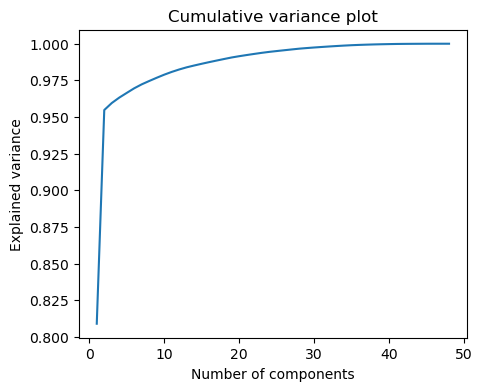

In [64]:
pca = PCA()
pca.fit(features)
plt.figure(figsize=(5,4))
plt.plot(range(1,len(features.columns)+1), pca.explained_variance_ratio_.cumsum())
plt.title('Cumulative variance plot')
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.show()

In [65]:
suma = 0
for i in range(10):
    suma += pca.explained_variance_ratio_[i]
print(f'Percentage of variance explained with only 10 components: {suma: .2%}')

Percentage of variance explained with only 10 components:  97.89%


In [66]:
#Setting the components to the parameter defined above
pca = PCA(n_components=10)
pca.fit(features)
new_features = pca.transform(features)

##### Elbow method
We will now tune the number of clusters used in the algorithm using the elbow method:
train a KMeans algorithm with a different value for the hyperparameter (number of clusters) and select a value that is not too high but performs well. 'Performs well' means that the inertia of the clusters is small.

Curiously, the plot below shows that 10 is also a good value for the number of clusters, so this is what we will use in the final version of the algorithm

In [67]:
#Use the elbow method to determine the optimal number of clusters
#It seems that the inertia starts to decrease more slowly at 10 clusters 

# num_clusters = [x for x in range(1, 55, 3)]
# inertias = []
# for k in num_clusters:
#     model = KMeans(n_clusters=k)
#     model.fit(new_features)
#     inertias.append(model.inertia_)
# plt.plot(num_clusters, inertias, '-o')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Inertia')
# plt.show()

In [68]:
#Final, trained (fitted) version of the KMeans algorithm
best_num_clusters = 10
model = KMeans(n_clusters=best_num_clusters)
model.fit(new_features)

KMeans(n_clusters=10)

##### Prediction and recomendation
Now, to output a recommendation from this clusters. 
1. predict cluster labels for the original dataframe, concatenate this new column
2. make a prediction of a new point. This will signal the cluster in which this new point belongs
3. output a recommendation from the people in the original dataset who are in the same cluster as the new point (are most similar)

In [69]:
label = model.predict(new_features)
df = df[df.index.isin(features.index)]
df['label'] = label.tolist()

In [70]:
new_point = []
for col in features.columns:
    value=int(input(f'enter value for: {col}  '))
    new_point.append(value)

KeyboardInterrupt: Interrupted by user

In [ ]:
new_point = np.array(new_point).reshape(1, 48)
new_point = scaler.transform(new_point)
pca_new_point = pca.transform(new_point)

In [ ]:
predicted_cluster = model.predict(pca_new_point)[0]
print(predicted_cluster)

In [ ]:
preferred_orientation = 'straight'
preferred_sex = 'f'
possible_recommendations = df[ (df['label']==predicted_cluster) 
                              & (df['sex']==preferred_sex) 
                              & (df['orientation']==preferred_orientation
                            )]
possible_recommendations

<hr>

## Conclusions
This project succesfully built a recommender engine that outputs recommended profiles from a dating app, it does so by using an unsupervised KMeans clustering algorithm to group profiles that are similar, and then assigning a group to the user that wants recommendations, the final set of recommendations is then output by selecting profiles from the same group as the user and filtered by some preferences. There are some improvements to be made to the recommendations, for example devising a user-friendly way to input data for new recommendations, and perhaps ranking the recommendations taking into account other filtering criteria.

## Further research
This project can be the starting point to test improvements to the recommendation engine proposed here, for example, one avenue to explore is to propose the engineering of different features. Many of the columns used were interpreted by the current researcher, but there are other ways to derive information fron the same columns.
Another possible path of improvement is to utilize other variables in the original dataset. There are many columns on the original dataset that were unused for this project, these can be used to conduct Natural Language Processing to enhance the recommendations given.
Finally, the same algorithm can be changed to add some variation to the recommendations, this could add serendipity to the final result set and improve user satistaction. Variation of this approach can be achieved for example, by creating different clusters according to filtering criteria, one concrete possibility is to create a different data set for every orientation, and then clustering for each one.
As we can see, this project is open to changes and improvements, the reader is invited to explore this paths and propose ideas of their own